In [89]:
import cv2
import pandas as pd
import numpy as np
import os
import sys
import configparser
import matplotlib.pyplot as plt

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout,Embedding,concatenate,Flatten
from keras.optimizers import RMSprop, Adam

#keras.applications.resnet.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)


sys.path.append(os.path.abspath('../../Module'))
import visualize

config = configparser.ConfigParser()
config.read('../../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']

data_dir = vg_json_export + 'extracted_data/'
output_dir = vg_json_export + 'feature_arrays/'
temp_output_dir = output_dir + 'temp/'
input_dir = vg_json_export + 'feature_arrays/'

size = False
test_ratio = 0.1
dev_ratio = 0.2
random_state = 123
num_splits = 4


In [68]:
# Objekt-DataFrame importieren
all_obj = pd.read_csv(vg_json_export+"extracted_data/all_objects.csv", index_col=0)
# Gezippte Numpy-Archive importieren
topdown_arrays = np.load(input_dir+'type_to_color_resampled.npz', allow_pickle=True)
train_x = topdown_arrays['train_x']
train_y = topdown_arrays['train_y']
test_x = topdown_arrays['test_x']
test_y = topdown_arrays['test_y']

In [90]:
# resnet-Modell laden
resnet = ResNet50(include_top=False)
#resnet.summary()
inpt = Input(shape=(224, 224, 3))
x = resnet(inpt)
out = Dense(903, activation='relu')(x)

# Freeze the layers except the last 4 layers
for layer in resnet.layers:
    layer.trainable = False

# Modell erstellen, der die Gewichte des letzten resnet-Dense-Layers ausgibt
model = Model(input=inpt, output=out)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
model.summary()

/home/simeon/Dokumente/Masterarbeit/environments/ma_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]
W0722 17:53:01.384103 140669579654976 deprecation_wrapper.py:119] From /home/simeon/Dokumente/Masterarbeit/environments/ma_env/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
dense_5 (Dense)              (None, 7, 7, 903)         1850247   
Total params: 25,437,959
Trainable params: 1,850,247
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
history = model.fit(train_x[:,1:], train_y[:,1:],
                    batch_size=batch_size,
                    epochs=5,
                    verbose=0,
                    validation_data=(test_td_x[:,1:].argmax(axis=1), test_y[:,1:]))
score = model.evaluate(test_td_x[:,1:].argmax(axis=1), test_y[:,1:], verbose=0)

In [62]:
img = all_obj.sample(1).iloc[0]
#features = construct_resnet_array(df, resnet, image_dir)
image = preprocess_image(img, image_dir)
predict = resnet.predict(image)

In [3]:
class out():
    x = np.empty((0,4097))
    x_temp = np.empty((0,4097))
    y = np.empty((0,12))
    y_temp = np.empty((0,12))

class status():
    state = None

def url(series, directory):
    return (directory + str(series.image_id) + '.jpg')

def preprocess_image(series, directory):

    # load an image from file
    input_image = load_img(url(series, directory))
    # convert the image pixels to a numpy array
    image = img_to_array(input_image)

    bb = {
        'h':series.bb_h,
        'w':series.bb_w,
        'x':series.bb_x,
        'y':series.bb_y
    }
    # Preprocessing using OpenCV
    try:
        # Bereich in BoundingBox selektieren
        image = image[bb['y']:bb['y']+bb['h'],bb['x']:bb['x']+bb['w']]
        # Bild auf richtige Größe
        image = cv2.resize(image, (224,224))
        # Grayscale to RGB
        if len(image.shape) < 3:
            image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    except Exception as ex:
        try:
            # Bild auf richtige Größe
            image = img_to_array(input_image)
            image = cv2.resize(image, (224,224))
            print('Error handling object {}. Resizing successfull. Error message: "{}"'.format(series.object_id, ex))
        except Exception as ex:
            print('Error handling object {}. Error message: "{}"'.format(series.object_id, ex))
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the resnet model
    image = preprocess_input(image)
    
    return(image)
    
def resnet_features(series, model, directory):
    image = preprocess_image(series, image_dir)
    predict = model.predict(image)
    out_obj = np.append(series.name,predict).reshape(1,-1)

    out.x_temp = np.append(out.x_temp, out_obj, axis=0)
    if len(out.x_temp) >= 1000:
        out.x = np.append(out.x, out.x_temp, axis=0)
        out.x_temp = np.empty((0,4097))
        print (status.state,len(out.x))

def construct_resnet_array(df, model, directory):
    out.x = np.empty((0,4097))
    out.x_temp = np.empty((0,4097))

    df.apply(lambda x: resnet_features(x, model, directory), axis=1)

    return (np.append(out.x, out.x_temp, axis=0))

In [4]:
all_obj = pd.read_csv(vg_json_export+"extracted_data/all_objects.csv", index_col=0)


/home/simeon/Dokumente/Masterarbeit/environments/ma_env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


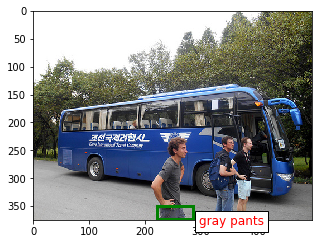

W0722 17:24:33.439036 140669579654976 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


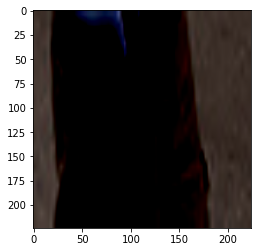

In [7]:
img = all_obj.sample(1).iloc[0]
visualize.plot_vg_image(img, image_dir)

plt.imshow(preprocess_image(img, image_dir)[0,:].astype(int))
plt.show()

In [67]:
# Objekt-DataFrame importieren
all_obj = pd.read_csv(vg_json_export+"extracted_data/all_objects.csv", index_col=0)
# Gezippte Numpy-Archive importieren
topdown_arrays = np.load(input_dir+'type_to_color_resampled.npz', allow_pickle=True)

train_ids = topdown_arrays['train_y'][:,0]
test_ids = topdown_arrays['test_x'][:,0]
dev_ids = topdown_arrays['dev_y'][:,0]

/home/simeon/Dokumente/Masterarbeit/environments/ma_env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:

status.state = 'Train'
ids = topdown_arrays['train_y'][:,0]
n = 0
for split in np.split(ids,num_splits):
    df = all_obj.loc[split]
    print('Shape current split: {}'.format(str(df.shape)))
    features = construct_resnet_array(df, model, image_dir)
    np.save(temp_output_dir+'train_x_{}.npy'.format(str(n)), features)
    print ('Split {} complete. Shape: {}'.format(n,features.shape))
    n += 1
print ('Train-Set Complete')

status.state = 'Dev'
ids = topdown_arrays['dev_y'][:,0]
n = 0
for split in [ids]:#np.split(ids,num_splits):
    df = all_obj.loc[split]
    print('Shape current split: {}'.format(str(df.shape)))
    features = construct_resnet_array(df, model, image_dir)
    np.save(temp_output_dir+'dev_x_{}.npy'.format(str(n)), features)
    print ('Split {} complete. Shape: {}'.format(n,features.shape))
    n += 1
print ('Dev-Set Complete')

status.state = 'Test'
ids = topdown_arrays['test_y'][:,0]
n = 0
for split in [ids]:#np.split(ids,num_splits):
    df = all_obj.loc[split]
    print('Shape current split: {}'.format(str(df.shape)))
    features = construct_resnet_array(df, model, image_dir)
    np.save(temp_output_dir+'test_x_{}.npy'.format(str(n)), features)
    print ('Split {} complete. Shape: {}'.format(n,features.shape))
    n += 1
print ('Test-Set Complete')
